# Performance figures

In [1]:
import numpy as np
import pandas as pd
from itertools import islice
from ast import literal_eval
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
%matplotlib inline
plt.rcParams.update({'font.size': 14})

## Baseline model performance
There were 3 baselines:
1. GPT3
    * Without relation embedding
    * With relation embedding
2. OpenIE
    * Without relation embedding
    * With relation embedding
3. My heuristic model
    * Model relies on relation embedding, so only includes relation embedding

Each was evaluated according to the following:
1. GPT3
    * Without relation embedding: evaluated without checking relation labels
    * With relation embedding: evaluated both with and without checking relation labels
2. OpenIE
    * Without relation embedding: evaluated without checking relation labels
    * With relation embedding: evaluated both with and without checking relation labels
3. My heuristic model
    * With relation embedding: evaluated with and without checking relation labels

### Reading in the data

In [2]:
data_paths = {
    
    'gpt3_no_embed_no_check':'../data/baselines/gpt3/10Mar_FINAL_TEST_no_rel_embed_performance.csv',
    'gpt3_embed_check':'../data/baselines/gpt3/10Mar_FINAL_TEST_embedded_rel_yes_check_rels_performance.csv',
    'gpt3_embed_no_check':'../data/baselines/gpt3/10Mar_FINAL_TEST_embedded_rel_no_check_rels_performance.csv',
    #'openIE_no_embed_no_check':,
    #'openIE_embed_check':,
    #'openIE_embed_no_check',
    'heuristic_check':'../data/distant_sup_output/09Mar_TEST_check_rels_performance.csv',
    'heuristic_no_check':'../data/distant_sup_output/09Mar_TEST_no_check_rels_performance.csv',
    'best_previous_no_embed_no_check':'../data/baselines/best_prev/10Mar_best_scierc_TEST_performance.csv'
}

In [3]:
# Read in all dfs
perf_dfs = {k:pd.read_csv(v) for k,v in data_paths.items()}
# Add model/eval name as last column to all
perf_df_list = []
for model_eval, df in perf_dfs.items():
    df['model_eval'] = model_eval
    perf_df_list.append(df)
# Concat
overall_perfs = pd.concat(perf_df_list)
overall_perfs

,precision,precision_CI,recall,recall_CI,F1,F1_CI,model_eval
0,0.011923,"(0.0, 0.023809523809523808)",0.010914,"(0.0, 0.02631578947368421)",0.011292,"(0.0, 0.024691358024691357)",gpt3_no_embed_no_check
0,0.000000,"(0.0, 0.0)",0.000000,"(0.0, 0.0)",0.000000,"(0.0, 0.0)",gpt3_embed_check
0,0.012005,"(0.0, 0.023255813953488372)",0.011105,"(0.0, 0.02631578947368421)",0.011423,"(0.0, 0.023676470588235285)",gpt3_embed_no_check
0,0.042277,"(0.0, 0.1)",0.011388,"(0.0, 0.02564102564102564)",0.017627,"(0.0, 0.03541666666666665)",heuristic_check
0,0.041411,"(0.0, 0.1)",0.010674,"(0.0, 0.02300475687103593)",0.016738,"(0.0, 0.036111111111111066)",heuristic_no_check
0,0.024002,"(0.0, 0.0625)",0.057803,"(0.0, 0.12057200929152143)",0.032782,"(0.0, 0.07086236113726228)",best_previous_no_embed_no_check


#### NOTE
I find these results very suspicious, for two reasons:
1. The performance of the heuristic alg is higher when checking the relation labels than when not. This shouldn't be possible, as anything evaluated as correct when checking rel labels should still be correct when evaluated without checking.
2. The performance of the heuristic algorithm is *drastically* worse than what it was the first time I ran it before making any of the changes that helped me drop way fewer sentences. Again, the performance should at least be the same, even if having access to more sentences didn't help, unless new sentences that weren't dropped before are now dropped, which I find that hard to beleive, as a huge number of sentences aren't dropped now. However, that original performance was evaluated on all documents, not just the test set; this observation could potentially be due to the specific documents in the test set? --> Should eval just the current test set out of the old predictions to test that hypothesis.

### Generating plots
#### F1

In [4]:
name_map = {
    
    'gpt3_no_embed_no_check':'GPT3, no label embedding',
    'gpt3_embed_check':'GPT3, label embedding',
    'gpt3_embed_no_check':'GPT3, unchecked label embedding',
    #'openIE_no_embed_no_check':,
    #'openIE_embed_check':,
    #'openIE_embed_no_check',
    'heuristic_check':'Heuristic, labels checked',
    'heuristic_no_check':'Heuristic, labels not checked',
    'best_previous_no_embed_no_check':'Best Previous (SciERC), labels not checked'
}

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

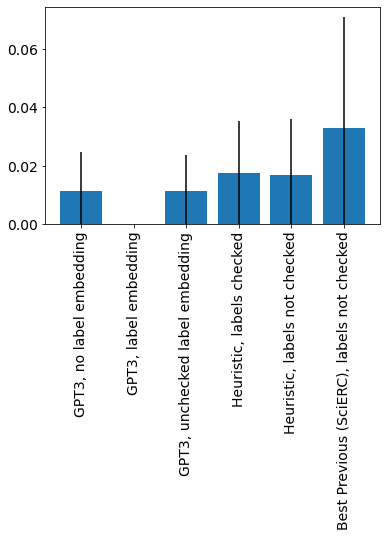

In [9]:
labels = [name_map[n] for n in overall_perfs.model_eval]
vals = overall_perfs.F1.values.tolist()
errors_up = [literal_eval(e)[1] - v for e, v in zip(overall_perfs.F1_CI, vals)]
errors_down = [v - literal_eval(e)[0] for e, v in zip(overall_perfs.F1_CI, vals)]
errors = [errors_down, errors_up]
plt.bar(labels, vals, yerr=errors)
plt.xticks(rotation=90)